# Deep learning example on image tiles

We will show, as an example, how to train a Dense Net which predicts cell types Xenium data from an associated H&E image.

In particular this example shows that:
- We can easily access and combine images and annotations across different technologies. For the sake of the example here we use the H&E image from Visium data, and the cell type information from overlapping Xenium data. Remarkably, the two modalities are spatially aligned via an affine transformation.
- We generate image tiles with full control of the spatial extent and the pixel resolution.
- We interface with popular frameworks for deep learning: Monai and PyTorch Lightning.

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black

In [2]:
import os
from typing import Dict

import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
import torch.multiprocessing as mp
from monai.networks.nets import DenseNet121
from pytorch_lightning import LightningDataModule
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger
from spatialdata import SpatialData, read_zarr, transform
from spatialdata.dataloader.datasets import ImageTilesDataset
from spatialdata.transformations import get_transformation
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
import spatialdata_plot  # noqa: F401

mp.set_start_method("spawn", force=True)

/opt/miniconda3/envs/ome_sdc/lib/python3.13/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/opt/miniconda3/envs/ome_sdc/lib/python3.13/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


## Preparing the data

### Getting the Zarr files

You can download the Visium and Xenium data from here: [Visium dataset](https://s3.embl.de/spatialdata/spatialdata-sandbox/visium_associated_xenium_io.zip), [Xenium dataset](https://s3.embl.de/spatialdata/spatialdata-sandbox/xenium_rep1_io.zip). Please rename the data to `xenium.zarr` and `visium.zarr`, or use symlinks to make the paths below accesible.

Information regarding data licensing and attribution for the dataset listed above is available at: https://github.com/scverse/spatialdata-notebooks/tree/main/datasets.

In [3]:
XENIUM_SDATA_PATH = "xenium.zarr"
VISIUM_SDATA_PATH = "visium.zarr"

assert os.path.isdir(XENIUM_SDATA_PATH)
assert os.path.isdir(VISIUM_SDATA_PATH)

xenium_sdata = read_zarr(XENIUM_SDATA_PATH)
visium_sdata = read_zarr(VISIUM_SDATA_PATH)

The downloaded data is not aligned (it requires alignment via an affine transformation) and also needs celltype annotations for the Xenium cells. 

The ["Alignemnt using landmarks" tutorial](alignment_using_landmarks.ipynb) shows how to achieve the alignment. 
[This analysis notebook](https://github.com/scverse/spatialdata-notebooks/blob/main/notebooks/paper_reproducibility/00_xenium_and_visium.ipynb) shows how the cell-types are mapped into the Xenium data. 

For the sake of simplifity and to keep the focus of this notebook on training a densenet to predict cell-types from image data, we will adjust the affine transformation with the aid of some utils functions, and we will add the cell-type information to the Xenium data using some precomputed information that we will download and merge with the `SpatialData` object on-the-fly.

In [4]:
from alignment_utils import AFFINE_VISIUM_XENIUM, postpone_transformation
from spatialdata.transformations import Identity

print(AFFINE_VISIUM_XENIUM)

postpone_transformation(
    sdata=visium_sdata,
    transformation=AFFINE_VISIUM_XENIUM,
    source_coordinate_system="CytAssist_FFPE_Human_Breast_Cancer",
    target_coordinate_system="aligned",
)
postpone_transformation(
    sdata=xenium_sdata,
    transformation=Identity(),
    source_coordinate_system="global",
    target_coordinate_system="aligned",
)

Affine (x, y -> x, y)
    [ 1.61711846e-01  2.58258090e+00 -1.24575040e+04]
    [-2.58258090e+00  1.61711846e-01  3.98647301e+04]
    [0. 0. 1.]


In [5]:
import os
from tempfile import TemporaryDirectory

import requests

url = "https://s3.embl.de/spatialdata/spatialdata-sandbox/generated_data/xenium_visium_integration/xenium_rep1_celltype_major.csv"

with TemporaryDirectory() as tmpdir:
    path = os.path.join(tmpdir, "data.csv")
    response = requests.get(url)
    with open(path, "wb") as f:
        f.write(response.content)
    df = pd.read_csv(path, index_col=0)
df

,celltype_major,cell_id
0,Normal Epithelial,1
1,Cancer Epithelial,2
2,Endothelial,3
3,Plasmablasts,4
4,Cancer Epithelial,5
...,...,...
167775,Cancer Epithelial,167776
167776,Cancer Epithelial,167777
167777,Cancer Epithelial,167778
167778,Cancer Epithelial,167779


In [6]:
xenium_sdata["table"].obs = pd.merge(xenium_sdata["table"].obs, df, on="cell_id")
xenium_sdata["table"].obs["celltype_major"] = xenium_sdata["table"].obs["celltype_major"].astype("category")

/opt/miniconda3/envs/ome_sdc/lib/python3.13/functools.py:929: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


In [7]:
xenium_sdata["table"].obs

,cell_id,transcript_counts,control_probe_counts,control_codeword_counts,total_counts,cell_area,nucleus_area,region,celltype_major
0,1,28,1,0,29,58.387031,26.642188,cell_circles,Normal Epithelial
1,2,94,0,0,94,197.016719,42.130781,cell_circles,Cancer Epithelial
2,3,9,0,0,9,16.256250,12.688906,cell_circles,Endothelial
3,4,11,0,0,11,42.311406,10.069844,cell_circles,Plasmablasts
4,5,48,0,0,48,107.652500,37.479688,cell_circles,Cancer Epithelial
...,...,...,...,...,...,...,...,...,...
167775,167776,229,1,0,230,220.452813,60.599688,cell_circles,Cancer Epithelial
167776,167777,79,0,0,79,37.389375,25.242344,cell_circles,Cancer Epithelial
167777,167778,397,0,0,397,287.058281,86.700000,cell_circles,Cancer Epithelial
167778,167779,117,0,0,117,235.354375,25.197188,cell_circles,Cancer Epithelial


Let's create a new `SpatialData` object with just the elements we are interest in. We will predict the Xenium cell types from the Visium image, so let's grab the cell circles and the table from the Xenium data, and the full resolution H&E image from Visium.

In [8]:
merged = SpatialData(
    images={
        "CytAssist_FFPE_Human_Breast_Cancer_full_image": visium_sdata.images[
            "CytAssist_FFPE_Human_Breast_Cancer_full_image"
        ],
    },
    shapes={
        "cell_circles": xenium_sdata.shapes["cell_circles"],
        "cell_boundaries": xenium_sdata.shapes["cell_boundaries"],
    },
    tables={"table": xenium_sdata["table"]},
)

For the sake of reducing the computational requirements to run this example, let's spatially subset the data.

In [9]:
adata_polygons = merged["table"].copy()

adata_polygons.uns["spatialdata_attrs"]["region"] = "cell_boundaries"
adata_polygons.obs["region"] = "cell_boundaries"
adata_polygons.obs["region"] = adata_polygons.obs["region"].astype("category")

del merged.tables["table"]
merged["table"] = adata_polygons

In [10]:
min_coordinate = [12790, 12194]
max_coordinate = [15100, 15221]
merged = merged.query.bounding_box(
    min_coordinate=min_coordinate,
    max_coordinate=max_coordinate,
    axes=["y", "x"],
    target_coordinate_system="aligned",
)

In [11]:
visium_sdata

SpatialData object, with associated Zarr store: /Users/macbook/embl/projects/basel/spatialdata-integration-testing/dependencies/spatialdata-sandbox/visium_associated_xenium_io/data.zarr
├── Images
│     ├── 'CytAssist_FFPE_Human_Breast_Cancer_full_image': DataTree[cyx] (3, 21571, 19505), (3, 10785, 9752), (3, 5392, 4876), (3, 2696, 2438), (3, 1348, 1219)
│     ├── 'CytAssist_FFPE_Human_Breast_Cancer_hires_image': DataArray[cyx] (3, 2000, 1809)
│     └── 'CytAssist_FFPE_Human_Breast_Cancer_lowres_image': DataArray[cyx] (3, 600, 543)
├── Shapes
│     ├── 'CytAssist_FFPE_Human_Breast_Cancer': GeoDataFrame shape: (4992, 2) (2D shapes)
│     └── 'visium_landmarks': GeoDataFrame shape: (3, 2) (2D shapes)
└── Tables
      └── 'table': AnnData (4992, 18085)
with coordinate systems:
    ▸ 'CytAssist_FFPE_Human_Breast_Cancer', with elements:
        CytAssist_FFPE_Human_Breast_Cancer_full_image (Images), CytAssist_FFPE_Human_Breast_Cancer_hires_image (Images), CytAssist_FFPE_Human_Breast_Cancer_

/Users/macbook/embl/projects/basel/spatialdata-integration-testing/dependencies/spatialdata-plot/src/spatialdata_plot/pl/utils.py:872: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_mapping)


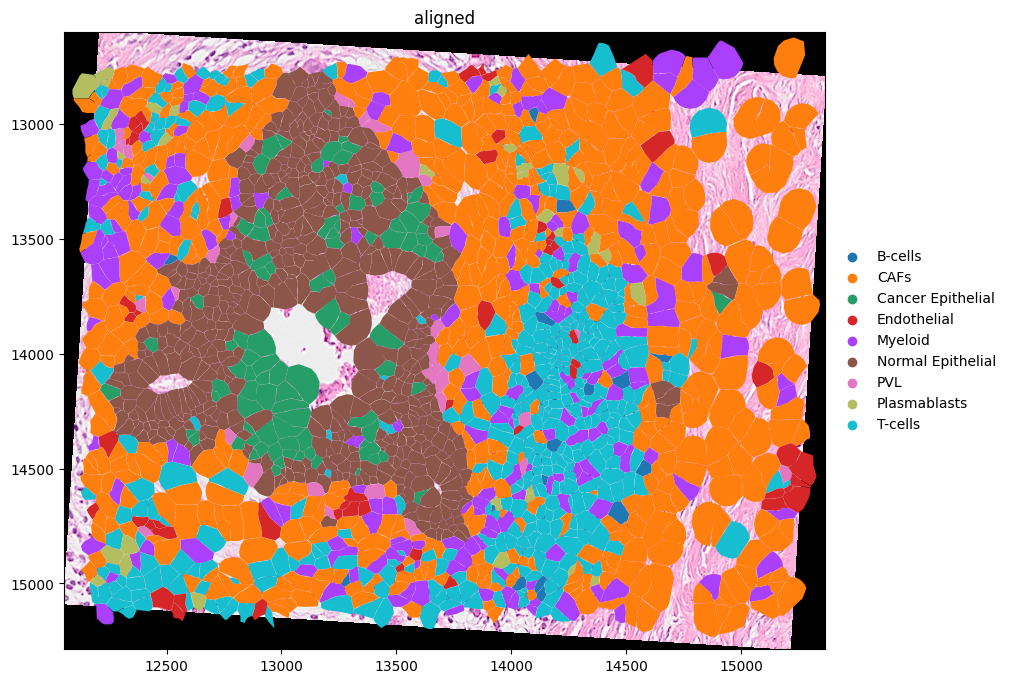

In [12]:
(
    merged.pl.render_images("CytAssist_FFPE_Human_Breast_Cancer_full_image")
    .pl.render_shapes("cell_boundaries", color="celltype_major")
    .pl.show(coordinate_systems=["aligned"], figsize=(10, 10))
)

In [13]:
merged["table"].uns

{'spatialdata_attrs': {'region': ['cell_boundaries'],
  'region_key': 'region',
  'instance_key': 'cell_id'}}

Here is a visualization of the image and cell type data. Notice how the Visium image is rotated with respect to the Xenium data.

![image.png](attachments/dense_net_cell_types.png)

Let's compute the mean Xenium cell diamater, we will use this to choose an appropriate image tile size.

In [14]:
circles = merged["cell_circles"]

transformed_circles = transform(circles, to_coordinate_system="aligned")
xenium_circles_diameter = 2 * np.mean(transformed_circles.radius)

Let's find the list of all the cell types we are dealing with.

In [15]:
cell_types = merged["table"].obs["celltype_major"].cat.categories.tolist()

We now effortlessly define a PyTorch `Dataset` for the `SpatialData` object using the class `ImageTileDataset()`.

In particular we want the following.
* We want the tile size to be 32 x 32 pixels.
* At the same time, we want each tile to have a spatial extent of 3 times the average Xenium cell diameter
* For each tile we want to extract the value of the `celltype_major` categorical column and encode this into a one-hot vector. We will use the `torchvision` transforms paradigma for achieving this.


**Technical note.**
There are some limitations when using PyTorch inside a Jupyter Notebook. Here we would need a function, that we call `my_transform()`, that we would use to apply a data transformation to the dataset. The function can't be defined here in the notebook so we will import it from a separate `Python` file. For more details please see here: https://stackoverflow.com/a/65001152.

Here is the function that we would like to define.
```python
def my_transform(sdata: SpatialData) -> tuple[torch.tensor, torch.tensor]:
    tile = sdata['CytAssist_FFPE_Human_Breast_Cancer_full_image'].data.compute()
    tile = torch.tensor(tile)
    
    expected_category = sdata["table"].obs['celltype_major'].values[0]
    expected_category = cell_types.index(expected_category)
    cell_type = F.one_hot(
        torch.tensor(expected_category), num_classes=len(cell_types)
    )
    return tile, cell_type
```

In [16]:
# let's import the above function
from densenet_utils import my_transform

dataset = ImageTilesDataset(
    sdata=merged,
    regions_to_images={"cell_boundaries": "CytAssist_FFPE_Human_Breast_Cancer_full_image"},
    regions_to_coordinate_systems={"cell_boundaries": "aligned"},
    table_name="table",
    tile_dim_in_units=3 * xenium_circles_diameter,
    transform=my_transform,
    rasterize=True,
    rasterize_kwargs={"target_width": 32},
)

dataset[0]

(tensor([[[124., 208., 241.,  ..., 255., 255., 238.],
          [255., 243., 247.,  ..., 255., 250., 235.],
          [251., 242., 254.,  ..., 246., 255., 255.],
          ...,
          [248., 249., 247.,  ..., 234., 246., 242.],
          [244., 245., 255.,  ..., 233., 252., 252.],
          [241., 245., 255.,  ..., 255., 255., 247.]],
 
         [[ 59., 129., 179.,  ..., 223., 190., 174.],
          [242., 171., 174.,  ..., 206., 178., 175.],
          [224., 173., 186.,  ..., 184., 205., 198.],
          ...,
          [172., 176., 175.,  ..., 153., 183., 193.],
          [169., 175., 181.,  ..., 153., 220., 255.],
          [169., 173., 178.,  ..., 236., 251., 195.]],
 
         [[123., 194., 220.,  ..., 242., 221., 209.],
          [255., 209., 217.,  ..., 234., 216., 211.],
          [241., 220., 225.,  ..., 223., 244., 232.],
          ...,
          [219., 222., 215.,  ..., 196., 212., 215.],
          [212., 211., 225.,  ..., 188., 233., 250.],
          [207., 210., 225.,  .

Let's now define a PyTorch Lightning data module to reduce the amount of boilerplate code we need to write.

In [17]:
class TilesDataModule(LightningDataModule):
    def __init__(self, batch_size: int, num_workers: int, dataset: torch.utils.data.Dataset):
        super().__init__()

        self.batch_size = batch_size
        self.num_workers = num_workers
        self.dataset = dataset

    def setup(self, stage=None):
        n_train = int(len(self.dataset) * 0.7)
        n_val = int(len(self.dataset) * 0.2)
        n_test = len(self.dataset) - n_train - n_val
        self.train, self.val, self.test = torch.utils.data.random_split(
            self.dataset,
            [n_train, n_val, n_test],
            generator=torch.Generator().manual_seed(42),
        )

    def train_dataloader(self):
        return DataLoader(
            self.train,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
        )

    def val_dataloader(self):
        return DataLoader(
            self.val,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
        )

    def test_dataloader(self):
        return DataLoader(
            self.test,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
        )

    def predict_dataloader(self):
        return DataLoader(
            self.dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
        )

Let's define the Dense Net, that we import from Monai.

In [18]:
class DenseNetModel(pl.LightningModule):
    def __init__(self, learning_rate: float, in_channels: int, num_classes: int):
        super().__init__()

        # store hyperparameters
        self.save_hyperparameters()

        self.loss_function = CrossEntropyLoss()

        # make the model
        self.model = DenseNet121(spatial_dims=2, in_channels=in_channels, out_channels=num_classes)

    def forward(self, x) -> torch.Tensor:
        return self.model(x)

    def _compute_loss_from_batch(self, batch: Dict[str, torch.Tensor], batch_idx: int) -> float:
        inputs = batch[0]
        labels = batch[1]

        outputs = self.model(inputs)
        return self.loss_function(outputs, labels)

    def training_step(self, batch: Dict[str, torch.Tensor], batch_idx: int) -> Dict[str, float]:
        # compute the loss
        loss = self._compute_loss_from_batch(batch=batch, batch_idx=batch_idx)

        # perform logging
        self.log("training_loss", loss, batch_size=len(batch[0]))

        return {"loss": loss}

    def validation_step(self, batch: Dict[str, torch.Tensor], batch_idx: int) -> float:
        loss = self._compute_loss_from_batch(batch=batch, batch_idx=batch_idx)

        imgs, labels = batch
        acc = self.compute_accuracy(imgs, labels)
        # By default logs it per epoch (weighted average over batches), and returns it afterwards
        self.log("test_acc", acc)

        return loss

    def test_step(self, batch, batch_idx):
        imgs, labels = batch
        acc = self.compute_accuracy(imgs, labels)
        # By default logs it per epoch (weighted average over batches), and returns it afterwards
        self.log("test_acc", acc)

    def predict_step(self, batch, batch_idx: int, dataloader_idx: int = 0):
        imgs, labels = batch
        preds = self.model(imgs).argmax(dim=-1)
        return preds

    def compute_accuracy(self, imgs, labels):
        preds = self.model(imgs).argmax(dim=-1)
        labels_value = torch.argmax(labels, dim=-1)
        acc = (labels_value == preds).float().mean()
        return acc

    def configure_optimizers(self) -> Adam:
        return Adam(self.model.parameters(), lr=self.hparams.learning_rate)

We are ready to train the model!

In [21]:
import os

import numpy as np
import pytorch_lightning as pl
import torch

pl.seed_everything(7)

PATH_DATASETS = os.environ.get("PATH_DATASETS", "..")
BATCH_SIZE = 4096 if torch.cuda.is_available() else 64
NUM_WORKERS = 10 if torch.cuda.is_available() else 4
print(f"Using {BATCH_SIZE} batch size.")
print(f"Using {NUM_WORKERS} workers.")

tiles_data_module = TilesDataModule(batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, dataset=dataset)

tiles_data_module.setup()
train_dl = tiles_data_module.train_dataloader()
val_dl = tiles_data_module.val_dataloader()
test_dl = tiles_data_module.test_dataloader()

num_classes = len(cell_types)
in_channels = dataset[0][0].shape[0]

model = DenseNetModel(
    learning_rate=1e-5,
    in_channels=in_channels,
    num_classes=num_classes,
)
import logging

logging.basicConfig(level=logging.INFO)

trainer = pl.Trainer(
    max_epochs=2,
    accelerator="auto",
    # devices=1,  # limiting got iPython runs. Edit: it works also without now
    logger=CSVLogger(save_dir="logs/"),
    callbacks=[
        LearningRateMonitor(logging_interval="step"),
        TQDMProgressBar(refresh_rate=5),
    ],
    log_every_n_steps=20,
)

INFO:lightning_fabric.utilities.seed:Seed set to 7
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


Using 64 batch size.
Using 4 workers.


In [22]:
trainer.fit(model, datamodule=tiles_data_module)
trainer.test(model, datamodule=tiles_data_module)

┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type             ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss_function │ CrossEntropyLoss │      0 │ train │     0 │
│ 1 │ model         │ DenseNet121      │  7.0 M │ train │     0 │
└───┴───────────────┴──────────────────┴────────┴───────┴───────┘

Trainable params: 7.0 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 7.0 M                                                                                                
Total estimated model params size (MB): 27                                                                         
Modules in train mode: 496                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Sanity Checking: |                                                                                            …

/opt/miniconda3/envs/ome_sdc/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:429: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
/opt/miniconda3/envs/ome_sdc/lib/python3.13/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/opt/miniconda3/envs/ome_sdc/lib/python3.13/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/opt/min

Training: |                                                                                                   …

/opt/miniconda3/envs/ome_sdc/lib/python3.13/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/opt/miniconda3/envs/ome_sdc/lib/python3.13/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/opt/miniconda3/envs/ome_sdc/lib/python3.13/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe

Validation: |                                                                                                 …

/opt/miniconda3/envs/ome_sdc/lib/python3.13/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/opt/miniconda3/envs/ome_sdc/lib/python3.13/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/opt/miniconda3/envs/ome_sdc/lib/python3.13/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe

Validation: |                                                                                                 …

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.
/opt/miniconda3/envs/ome_sdc/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:429: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.
/opt/miniconda3/envs/ome_sdc/lib/python3.13/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/opt/miniconda3/envs/ome_sdc/lib/python3.13/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to

Testing: |                                                                                                    …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.36125653982162476    │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.36125653982162476}]

In [23]:
# model = DenseNetModel.load_from_checkpoint('logs/lightning_logs/version_12/checkpoints/epoch=1-step=40.ckpt')

# disable randomness, dropout, etc...
model.eval()

trainer = pl.Trainer(
    accelerator="auto",
    devices=1,
    callbacks=[
        TQDMProgressBar(refresh_rate=10),
    ],
)

predictions = trainer.predict(datamodule=tiles_data_module, model=model)
predictions = torch.cat(predictions, dim=0)

print(np.unique(predictions.detach().cpu().numpy(), return_counts=True))

INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
/opt/miniconda3/envs/ome_sdc/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/opt/miniconda3/envs/ome_sdc/lib/python3.13/s

Predicting: |                                                                                                 …

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([ 62, 438,  51,  77, 293, 297,  21,  23, 637]))


In [35]:
p = predictions.detach().cpu().numpy()
predicted_celltype_major = []
for i in p:
    predicted_celltype_major.append(cell_types[i])
s = pd.Series(predicted_celltype_major)
categorical = pd.Categorical(s, categories=cell_types)

categorical.index = merged["table"].obs.index
merged["table"].obs["predicted_celltype_major"] = categorical

/Users/macbook/embl/projects/basel/spatialdata-integration-testing/dependencies/spatialdata-plot/src/spatialdata_plot/pl/utils.py:872: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_mapping)
/Users/macbook/embl/projects/basel/spatialdata-integration-testing/dependencies/spatialdata-plot/src/spatialdata_plot/pl/utils.py:872: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_mapping)


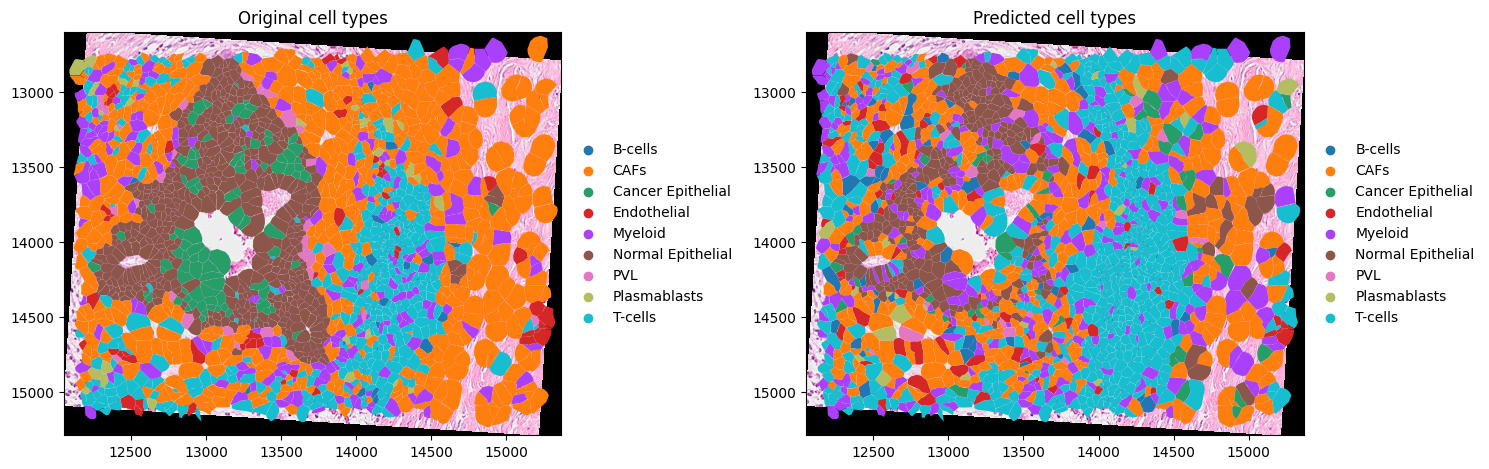

In [36]:
import matplotlib.pyplot as plt

axes = plt.subplots(1, 2, figsize=(15, 7))[1]
(
    merged.pl.render_images("CytAssist_FFPE_Human_Breast_Cancer_full_image")
    .pl.render_shapes("cell_boundaries", color="celltype_major")
    .pl.show(coordinate_systems=["aligned"], ax=axes[0], title="Original cell types")
)
(
    merged.pl.render_images("CytAssist_FFPE_Human_Breast_Cancer_full_image")
    .pl.render_shapes("cell_boundaries", color="predicted_celltype_major")
    .pl.show(coordinate_systems=["aligned"], ax=axes[1], title="Predicted cell types")
)
plt.tight_layout()

Here are the precitions from the model (napari screenshot).

![image.png](attachments/dense_net_predicted.png)

## Visualizing the tiles

In [37]:
x = np.array([13694.0, 13889.0, 13889.0, 13694.0, 13694.0])
y = np.array([13984.0, 13984.0, 14162.0, 14162.0, 13984.0])

small_sdata = merged.query.bounding_box(
    axes=("x", "y"),
    min_coordinate=[np.min(x), np.min(y)],
    max_coordinate=[np.max(x), np.max(y)],
    target_coordinate_system="aligned",
)
small_sdata

SpatialData object
├── Images
│     └── 'CytAssist_FFPE_Human_Breast_Cancer_full_image': DataTree[cyx] (3, 79, 73), (3, 40, 36), (3, 20, 19), (3, 10, 9), (3, 5, 4)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (13, 1) (2D shapes)
│     └── 'cell_circles': GeoDataFrame shape: (8, 2) (2D shapes)
└── Tables
      └── 'table': AnnData (13, 313)
with coordinate systems:
    ▸ 'CytAssist_FFPE_Human_Breast_Cancer', with elements:
        CytAssist_FFPE_Human_Breast_Cancer_full_image (Images)
    ▸ 'aligned', with elements:
        CytAssist_FFPE_Human_Breast_Cancer_full_image (Images), cell_boundaries (Shapes), cell_circles (Shapes)
    ▸ 'global', with elements:
        cell_boundaries (Shapes), cell_circles (Shapes)

In [38]:
small_dataset = ImageTilesDataset(
    sdata=small_sdata,
    regions_to_images={"cell_boundaries": "CytAssist_FFPE_Human_Breast_Cancer_full_image"},
    regions_to_coordinate_systems={"cell_boundaries": "aligned"},
    tile_dim_in_units=100,
    rasterize=True,
    rasterize_kwargs={"target_width": 32},
    table_name="table",
    transform=None,
)

small_dataset[0]

SpatialData object
├── Images
│     └── 'CytAssist_FFPE_Human_Breast_Cancer_full_image': DataArray[cyx] (3, 32, 32)
└── Tables
      └── 'table': AnnData (1, 313)
with coordinate systems:
    ▸ 'aligned', with elements:
        CytAssist_FFPE_Human_Breast_Cancer_full_image (Images)

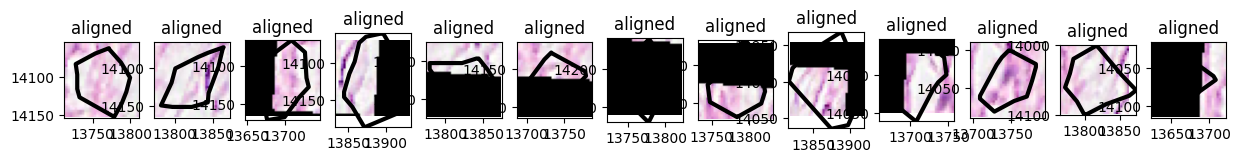

In [41]:
import matplotlib.pyplot as plt
import spatialdata as sd
from geopandas import GeoDataFrame
from spatialdata.models import ShapesModel

n = len(small_dataset)
axes = plt.subplots(1, n, figsize=(15, 3))[1]
for sdata_tile, i in zip(small_dataset, range(n)):
    region, instance_id = small_dataset.dataset_index.iloc[i][["region", "instance_id"]]
    shapes = small_sdata[region]
    transformations = get_transformation(shapes, get_all=True)
    tile = ShapesModel.parse(GeoDataFrame(geometry=shapes.loc[instance_id]), transformations=transformations)
    # BUG: we need to explicitly remove the coordinate system global if we want to combine
    # images and shapes plots into a single subplot
    # https://github.com/scverse/spatialdata-plot/issues/176
    sdata_tile["cell_boundaries"] = tile
    if "global" in get_transformation(sdata_tile["cell_boundaries"], get_all=True):
        sd.transformations.remove_transformation(sdata_tile["cell_boundaries"], "global")
    sdata_tile.pl.render_images().pl.render_shapes(
        # outline_color='predicted_celltype_major',  # not yet supported: https://github.com/scverse/spatialdata-plot/issues/137
        outline_width=3.0,
        outline=True,
        fill_alpha=0.0,
    ).pl.show(
        ax=axes[i],
    )